# Vehicle Type Classification with **Random Forest**

## Loading the data

In [26]:
import pandas as pd

# Load the dataset
file_path = "/Users/jakob/Library/CloudStorage/OneDrive-student.kit.edu/Studium/02_Master/4. Semester/seminar/RoadTrafficNoise/IDMT-Traffic/datasets/df_main_encoded_only.csv"

# Load the dataset
df_vehicle_classification = pd.read_csv(file_path)

# Display the first few rows
print(df_vehicle_classification.head())

# Check column names and data types
print(df_vehicle_classification.info())

   Unnamed: 0                                               file  \
0          18  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1116695...   
1          19  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1116695...   
2          20  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1137602...   
3          21  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1137602...   
4          24  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1141442...   

   is_background_encoded  date_time_encoded  location_encoded  \
0                      0                  0                 0   
1                      0                  0                 0   
2                      0                  0                 0   
3                      0                  0                 0   
4                      0                  0                 0   

   speed_kmh_encoded  daytime_encoded  weather_encoded  vehicle_encoded  \
0                  0                1                0                1   
1                  0                1             

## Baseline Models

### Baseline RF Model without using class weights (discarding class 3 from the beginning due to faulty data)

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Filter out rows where vehicle_encoded == 3
df_filtered = df_vehicle_classification[df_vehicle_classification['vehicle_encoded'] != 3]

# Define features (X) and target (y)
X = df_filtered.drop(columns=["file", "is_background_encoded", "vehicle_encoded", "Unnamed: 0", 'location_encoded', 'speed_kmh_encoded'])
y = df_filtered["vehicle_encoded"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.99      1.00      1.00      1561
           2       1.00      0.99      0.99        86

    accuracy                           0.99      1668
   macro avg       0.95      0.84      0.88      1668
weighted avg       0.99      0.99      0.99      1668



### with class weights:

In [28]:
# Initialize and train the RandomForestClassifier
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.48      0.61        21
           1       0.99      1.00      1.00      1561
           2       1.00      0.99      0.99        86

    accuracy                           0.99      1668
   macro avg       0.94      0.82      0.87      1668
weighted avg       0.99      0.99      0.99      1668



## Final results:

Hyperparameter tuning with grid search:

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Filter out rows where vehicle_encoded == 3
df_filtered = df_vehicle_classification[df_vehicle_classification['vehicle_encoded'] != 3]

# Extract features and target
X = df_filtered.drop(columns=['file', 'vehicle_encoded', 'is_background_encoded', 'Unnamed: 0', 'date_time_encoded', 'location_encoded', 'speed_kmh_encoded'])  # Drop columns that could lead to data leakage or are not useful
y = df_filtered['vehicle_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],    # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]       # Whether bootstrap samples are used when building trees
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best parameters and retrain the model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
rf_clf_tuned = grid_search.best_estimator_

# Evaluate the tuned Random Forest model
y_pred_tuned = rf_clf_tuned.predict(X_test)
print("Classification Report with Tuned Random Forest:")
print(classification_report(y_test, y_pred_tuned))

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Classification Report with Tuned Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        21
           1       0.99      1.00      1.00      1561
           2       0.99      0.95      0.97        86

    accuracy                           0.99      1668
   macro avg       0.94      0.89      0.91      1668
weighted avg       0.99      0.99      0.99      1668



Smaller, refinded grid based on these results:

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Filter out rows where vehicle_encoded == 3
df_filtered = df_vehicle_classification[df_vehicle_classification['vehicle_encoded'] != 3]

# Extract features and target
X = df_filtered.drop(columns=['file', 'vehicle_encoded', 'is_background_encoded', 'Unnamed: 0', 'date_time_encoded', 'location_encoded', 'speed_kmh_encoded'])  # Drop columns that could lead to data leakage or are not useful
y = df_filtered['vehicle_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [150, 200, 250],       
    'max_depth': [None, 2, 3],                
    'min_samples_split': [5, 10, 15],        
    'min_samples_leaf': [1, 2, 4],           
    'bootstrap': [False]                      
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best parameters and retrain the model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
rf_clf_tuned = grid_search.best_estimator_

# Evaluate the tuned Random Forest model
y_pred_tuned = rf_clf_tuned.predict(X_test)
print("Classification Report with Tuned Random Forest:")
print(classification_report(y_test, y_pred_tuned))  

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Classification Report with Tuned Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        21
           1       0.99      1.00      1.00      1561
           2       0.99      0.95      0.97        86

    accuracy                           0.99      1668
   macro avg       0.94      0.89      0.91      1668
weighted avg       0.99      0.99      0.99      1668



No improvement.

Calculate Cross-Validation Accuracy Scores, Feature Importance and Confusion Matrix

In [35]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the tuned model
cv_scores = cross_val_score(rf_clf_tuned, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

Cross-Validation Accuracy Scores: [0.98951311 0.99325337 0.98950525 0.99025487 0.994003  ]
Mean CV Accuracy: 0.9913059200736709
Standard Deviation of CV Accuracy: 0.0019301866294641284


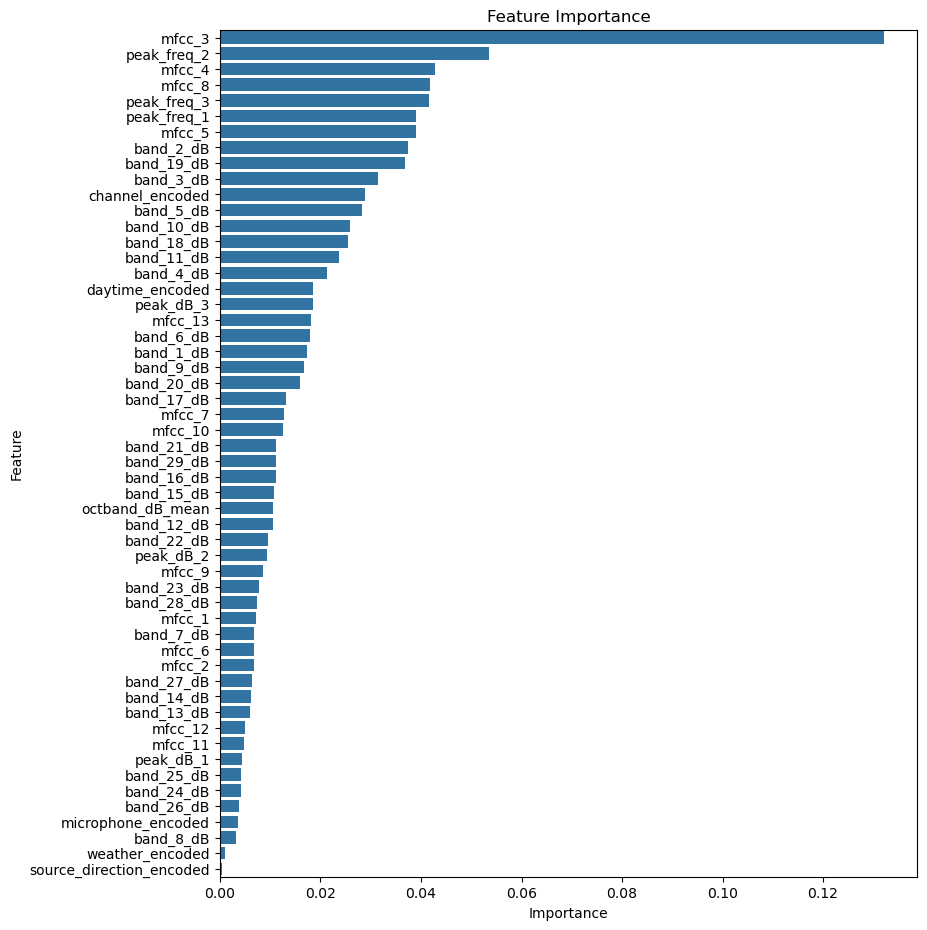

In [43]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(9, 11))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
sns.color_palette("Paired")
plt.title('Feature Importance')
plt.show()

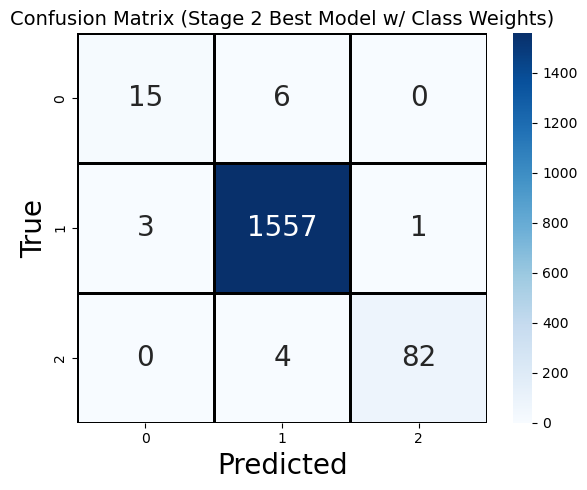

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)

# Create the plot
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap="Blues",
    linewidths=1,  # Adds line separators
    linecolor='black',  # Line color
    annot_kws={"size": 20}  # Increases font size for numbers
)

# Titles and labels
plt.title("Confusion Matrix (Stage 2 Best Model w/ Class Weights)", fontsize=14)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()